<a href="https://colab.research.google.com/github/omar16100/Topic-Modelling-NLP/blob/master/Topic_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import nltk

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# word cloud text visualization
from wordcloud import WordCloud, STOPWORDS
import xgboost as xgb
from tqdm import tqdm
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from nltk.stem import WordNetLemmatizer

Using TensorFlow backend.


In [0]:
data = pd.read_csv('/content/drive/My Drive/IIUM/5 nlp/train.csv')
texts = pd.read_csv('/content/drive/My Drive/IIUM/5 nlp/train.csv')

## Data Description
The competition dataset contains text from works of fiction written by spooky authors of the public domain: Edgar Allan Poe, HP Lovecraft and Mary Shelley. The data was prepared by chunking larger texts into sentences using CoreNLP's MaxEnt sentence tokenizer, so you may notice the odd non-sentence here and there. Your objective is to accurately identify the author of the sentences in the test set.

### File descriptions
train.csv - the training set
test.csv - the test set
sample_submission.csv - a sample submission file in the correct format
### Data fields
- id - a unique identifier for each sentence
- text - some text written by one of the authors
- author - the author of the sentence (EAP: Edgar Allan Poe, HPL: HP Lovecraft; MWS: Mary Wollstonecraft Shelley)


#Exploratory Data Analysis

In [0]:
data.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [0]:
data.describe()

,id,text,author
count,19579,19579,19579
unique,19579,19579,3
top,id10651,"I would not dare,"" he continued to mutter.",EAP
freq,1,1,7900


Find Out How Often Each Author Uses Each Word

In [0]:
### Split data

# split the data by author
byAuthor = texts.groupby("author")

### Tokenize (split into individual words) our text

# word frequency by author
wordFreqByAuthor = nltk.probability.ConditionalFreqDist()

# for each author...
for name, group in byAuthor:
    # get all of the sentences they wrote and collapse them into a
    # single long string
    sentences = group['text'].str.cat(sep = ' ')
    
    # convert everything to lower case (so "The" and "the" get counted as 
    # the same word rather than two different words)
    sentences = sentences.lower()
    
    # split the text into individual tokens    
    tokens = nltk.tokenize.word_tokenize(sentences)
    
    # calculate the frequency of each token
    frequency = nltk.FreqDist(tokens)

    # add the frequencies for each author to our dictionary
    wordFreqByAuthor[name] = (frequency)
    
# now we have an dictionary where each entry is the frequency distrobution
# of words for a specific author.     

Now we can look at how often each writer uses specific words. Since this is a Halloween competition, how about "blood", "scream" and "fear"?

In [0]:
# see how often each author says "blood"
for i in wordFreqByAuthor.keys():
    print("blood: " + i)
    print(wordFreqByAuthor[i].freq('blood'))

# print a blank line
print()

# see how often each author says "scream"
for i in wordFreqByAuthor.keys():
    print("scream: " + i)
    print(wordFreqByAuthor[i].freq('scream'))
    
# print a blank line
print()

# see how often each author says "fear"
for i in wordFreqByAuthor.keys():
    print("fear: " + i)
    print(wordFreqByAuthor[i].freq('fear'))

blood: EAP
0.00014646397201676582
blood: HPL
0.00022992337803427008
blood: MWS
0.00022773011333545174

scream: EAP
1.7231055531384214e-05
scream: HPL
9.196935121370803e-05
scream: MWS
2.6480245736680435e-05

fear: EAP
0.00010338633318830528
fear: HPL
0.0005748084450856752
fear: MWS
0.0006196377502383222


Use word frequency to guess which author wrote a sentence.
The general idea is that different people tend to use different words more or less often. (Our beloved Madam Suriani uses 'basically' more frequently while giving the lecture.) If you're not sure who said something but it has a lot of words one person uses a lot in it, then you might guess that they were the one who wrote it.

Let's use this general principle to guess who might have been more likely to write the sentence "It was a dark and stormy night."

In [0]:
# One way to guess authorship is to use the joint probabilty that each 
# author used each word in a given sentence.

# first, let's start with a test sentence
testSentence = "It was a dark and stormy night."

# and then lowercase & tokenize our test sentence
preProcessedTestSentence = nltk.tokenize.word_tokenize(testSentence.lower())

# create an empy dataframe to put our output in
testProbailities = pd.DataFrame(columns = ['author','word','probability'])

# For each author...
for i in wordFreqByAuthor.keys():
    # for each word in our test sentence...
    for j  in preProcessedTestSentence:
        # find out how frequently the author used that word
        wordFreq = wordFreqByAuthor[i].freq(j)
        # and add a very small amount to every prob. so none of them are 0
        smoothedWordFreq = wordFreq + 0.000001
        # add the author, word and smoothed freq. to our dataframe
        output = pd.DataFrame([[i, j, smoothedWordFreq]], columns = ['author','word','probability'])
        testProbailities = testProbailities.append(output, ignore_index = True)

# empty dataframe for the probability that each author wrote the sentence
testProbailitiesByAuthor = pd.DataFrame(columns = ['author','jointProbability'])

# now let's group the dataframe with our frequency by author
for i in wordFreqByAuthor.keys():
    # get the joint probability that each author wrote each word
    oneAuthor = testProbailities.query('author == "' + i + '"')
    jointProbability = oneAuthor.product(numeric_only = True)[0]
    
    # and add that to our dataframe
    output = pd.DataFrame([[i, jointProbability]], columns = ['author','jointProbability'])
    testProbailitiesByAuthor = testProbailitiesByAuthor.append(output, ignore_index = True)

# and our winner is...
testProbailitiesByAuthor.loc[testProbailitiesByAuthor['jointProbability'].idxmax(),'author']

'HPL'

Plot Count And Word Cloud

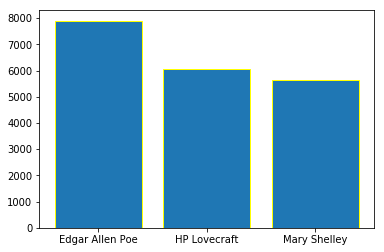

In [0]:
def plot_count():
  """
  This functin retun a bar plot for each author count appear in train set 
  """
  z = {'EAP': 'Edgar Allen Poe', 'MWS': 'Mary Shelley', 'HPL': 'HP Lovecraft'}
  
  # mapping authro short name to full name
  x = data.author.map(z).unique()
  
  # getting count for each author text appear in train dataset
  y = data.author.value_counts().values
  
  plt.bar(x,y, edgecolor='yellow')
  plt.show()
  
  
plot_count()

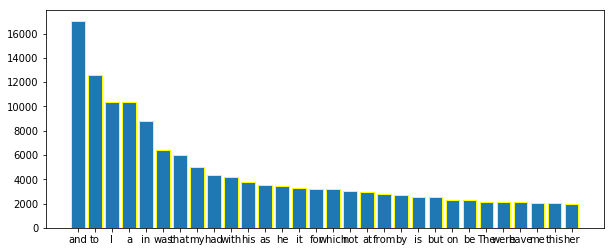

In [0]:
def plot_words_count():
  """
  This function will return a bar plot for first 30 words counts appears in dataset
  """
  # getting all words and their count of occurances
  words = data.text.str.split(expand=True).unstack().value_counts()
  
  # selecting 30 words
  x = words.index.values[2:32]
  y = words.values[2:32]
  
  # plotting barplot
  fig = plt.figure()
  fig.set_figwidth(10)
  plt.bar(x,y, edgecolor = 'yellow')
  
plot_words_count()

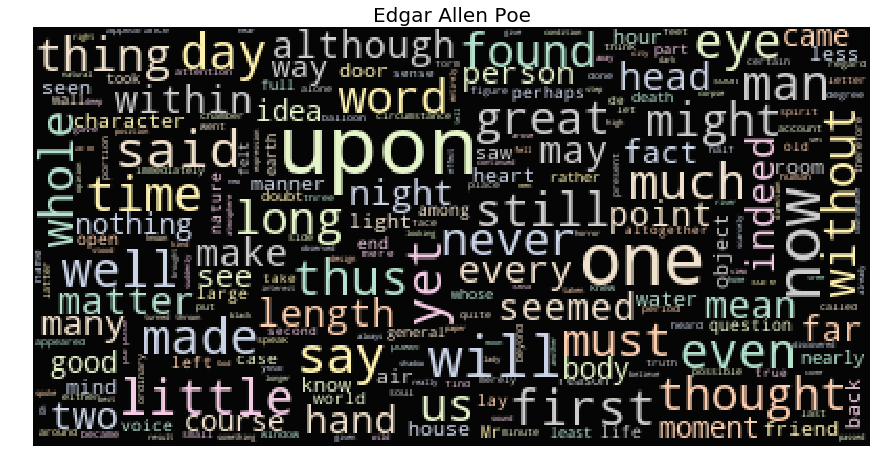

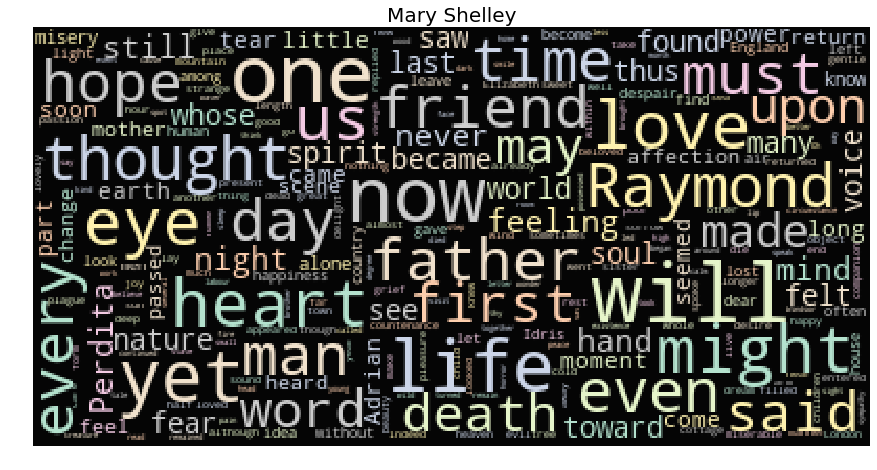

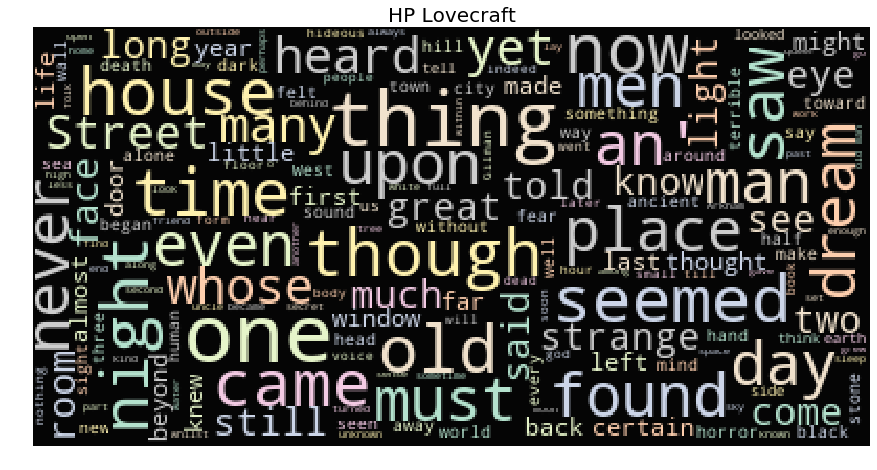

In [0]:
def word_cloud_viz():
  """
  This function will return word_cloud visualization of words for each author text
  """
  # python list that store text of three author
  eap = data[data.author=="EAP"]["text"].values
  hpl = data[data.author=="HPL"]["text"].values
  mws = data[data.author=="MWS"]["text"].values
  # z = {'EAP': 'Edgar Allen Poe', 'MWS': 'Mary Shelley', 'HPL': 'HP Lovecraft'}

  # plotting Edgar Allen Poe word_cloud
  plt.figure(figsize=(15, 10))
  wc = WordCloud(background_color="black", max_words=10000, stopwords=STOPWORDS, max_font_size=40)
  wc.generate(" ".join(eap))
  plt.title("Edgar Allen Poe", fontsize=20)
  plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
  plt.axis('off')

  
  # plotting Edgar Allen Poe word_cloud
  plt.figure(figsize=(15, 10))
  wc = WordCloud(background_color="black", max_words=10000, stopwords=STOPWORDS, max_font_size=40)
  wc.generate(" ".join(mws))
  plt.title("Mary Shelley", fontsize=20)
  plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
  plt.axis('off')
  
  
  # plotting Edgar Allen Poe word_cloud
  plt.figure(figsize=(15, 10))
  wc = WordCloud(background_color="black", max_words=10000, stopwords=STOPWORDS, max_font_size=40)
  wc.generate(" ".join(hpl))
  plt.title("HP Lovecraft", fontsize=20)
  plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
  plt.axis('off')
  
  
word_cloud_viz()

In [0]:
# invoking lemmatizer from nltk
# here we are customizing sklearn count vectorizer class. We are including lemmalizer along with it
# so that our preprocessin can be done with one place

lemma = WordNetLemmatizer()
class LemmaCountVectorizer(CountVectorizer):
  def build_analyzer(self):
    analyzer = super(LemmaCountVectorizer, self).build_analyzer()
    return lambda doc: (lemma.lemmatize(w) for w in analyzer(doc))

In [0]:
# level encoding of our target variables
label_encoder = preprocessing.LabelEncoder()
y = label_encoder.fit_transform(data.author.values)

In [0]:
# train test spliting
x_train, x_test, y_train, y_test = train_test_split(data.text.values, y,
                                                    stratify=y,
                                                    random_state=42,
                                                    test_size=0.1,
                                                    shuffle=True)

In [0]:
# vectorizing along with preprocessing
tf_vectorizer = LemmaCountVectorizer(min_df=3,
                                     max_features=None, 
                                     strip_accents='unicode',
                                     analyzer='word',token_pattern=r'\w{1,}',
                                     ngram_range=(1, 3),
                                     #use_idf=1,
                                     #smooth_idf=1,
                                     #sublinear_tf=1,
                                     stop_words = 'english')

tf_vectorizer.fit(list(x_train) + list(x_test))
tf_train = tf_vectorizer.transform(x_train)
tf_test = tf_vectorizer.transform(x_test)

In [0]:
all_score = dict()

In [0]:
# first model -> logistic regression model
classifier = LogisticRegression(C=1.0)

# fitting data into model
classifier.fit(tf_train, y_train)

# evaluating score
score = classifier.score(tf_test, y_test)

# storing score in dictionary
all_score['logistic regression'] =  score

# printing score
print("Score of Logistic Regression: ", score)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Score of Logistic Regression:  0.806435137895812


In [0]:
# Naive Bayes Classifier
NBclassifier = MultinomialNB()

# fitting data into model
NBclassifier.fit(tf_train, y_train)

# evaluating score
score = NBclassifier.score(tf_test, y_test)

# storing score in dictionary
all_score['Naive Bayes'] =  score

# printing score
print("Score of Naive Bayes Model: ", score)

Score of Naive Bayes Model:  0.8253319713993871


In [0]:
# XGBoost Classifier
XGBclassifier = xgb.XGBClassifier(max_depth=7,
                                  n_estimators=200,
                                  colsample_bytree=0.8,
                                  subsample=0.8,
                                  nthread=10,
                                  learning_rate=0.1)

# fitting data into model
XGBclassifier.fit(tf_train, y_train)

# evaluating score
score = XGBclassifier.score(tf_test, y_test)

# storing score in dictionary
all_score['XGBoost'] =  score

# printing score
print("Score of XGBoost Classifier Model: ", score)

Score of XGBoost Classifier Model:  0.6772216547497446


## Performance Comparison

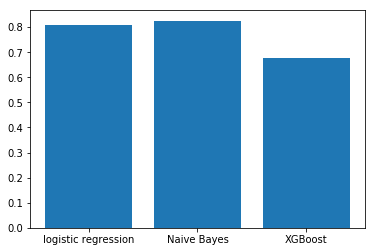

In [0]:
def show_com():

  model_name = [model for model in all_score.keys()]
  score = [score for score in all_score.values()]

  plt.bar(model_name, score)
  plt.show()
  

show_com()